# Загрузка данных

Требуется сегментировать изображения новообразований на коже из датасета ADDI Project с помощью одного из предложенных методов(Graph-based segmentation, Normalized cuts, Свёрточные нейронные сети). При использовании нейронных сетей выборку разделить на train/test/validation в соотношении 100/50/50. Качество модели оценивать с помощью метрики IoU.

Подгрузка датасета:

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...


Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

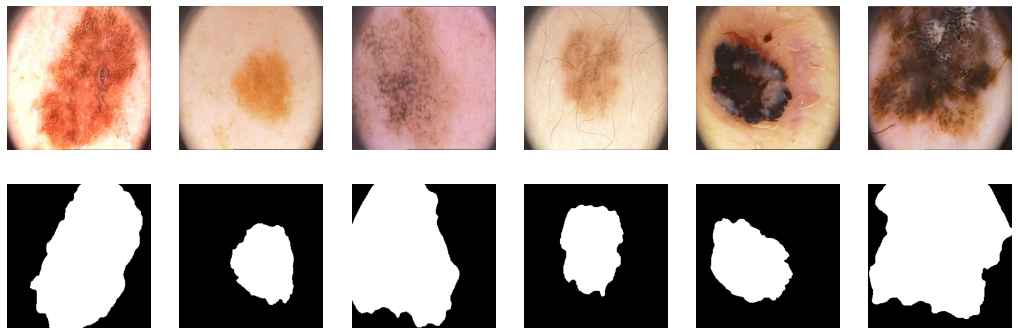

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i], cmap='gray')

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import pandas as pd
from matplotlib import rcParams
import matplotlib.image as mpimg
rcParams['figure.figsize'] = (15,4)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor): 
    outputs = outputs.squeeze(1).cpu().byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).cpu().byte()

    plt.figure(figsize=(12,3))
    for k in range(5):
        plt.subplot(2, 6, k+1)
        plt.imshow(labels[k], cmap='gray')
        plt.title('labels')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(outputs[k], cmap='gray')
        plt.title('outputs')
        plt.axis('off')


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

-----------------------------------------------------------------------------------------

# SegNet

## SegNet (Class)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        padd = 1
        kernel = 3

        # 1 
        self.enc_conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn1_1 = nn.BatchNorm2d(num_features=64)
            
        self.enc_conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn1_2 = nn.BatchNorm2d(num_features=64)

        # 2
        self.enc_conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn2_1 = nn.BatchNorm2d(num_features=128)

        self.enc_conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn2_2 = nn.BatchNorm2d(num_features=128)

        # 3
        self.enc_conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn3_1 = nn.BatchNorm2d(num_features=256)

        self.enc_conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn3_2 = nn.BatchNorm2d(num_features=256)

        self.enc_conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn3_3 = nn.BatchNorm2d(num_features=256)

        # 4
        self.enc_conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn4_1 = nn.BatchNorm2d(num_features=512)
        
        self.enc_conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn4_2 = nn.BatchNorm2d(num_features=512)
        
        self.enc_conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn4_3 = nn.BatchNorm2d(num_features=512)

        # 5 (bottleneck)
        self.enc_conv5_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=kernel, stride=1, padding=padd)
        self.bn5_1 = nn.BatchNorm2d(num_features=1024)

                                    # GO BACK!
        
        # 1 (bottleneck)
        self.dec_conv1_1 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn1_1 = nn.BatchNorm2d(num_features=512)

        # 2
        self.dec_conv2_1 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn2_1 = nn.BatchNorm2d(num_features=256) 

        self.dec_conv2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn2_2 = nn.BatchNorm2d(num_features=256) 

        self.dec_conv2_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn2_3 = nn.BatchNorm2d(num_features=256) 

        # 3
        self.dec_conv3_1 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn3_1 = nn.BatchNorm2d(num_features=128) 

        self.dec_conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn3_2 = nn.BatchNorm2d(num_features=128)

        self.dec_conv3_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn3_3 = nn.BatchNorm2d(num_features=128)

        # 4
        self.dec_conv4_1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn4_1 = nn.BatchNorm2d(num_features=64)

        self.dec_conv4_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn4_2 = nn.BatchNorm2d(num_features=64)

        # 5
        self.dec_conv5_1 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=kernel, stride=1, padding=padd)
        self.dec_bn5_1 = nn.BatchNorm2d(num_features=1)

        self.dec_conv5_2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel, stride=1, padding=padd)


    def forward(self, x):
        # 1
        x = F.relu(self.bn1_1(self.enc_conv1_1(x)), inplace=True)
        x = F.relu(self.bn1_2(self.enc_conv1_2(x)), inplace=True)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        # 2
        x = F.relu(self.bn2_1(self.enc_conv2_1(x)), inplace=True)
        x = F.relu(self.bn2_2(self.enc_conv2_2(x)), inplace=True)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        # 3
        x = F.relu(self.bn3_1(self.enc_conv3_1(x)), inplace=True)
        x = F.relu(self.bn3_2(self.enc_conv3_2(x)), inplace=True)
        x = F.relu(self.bn3_3(self.enc_conv3_3(x)), inplace=True)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        # 4
        x = F.relu(self.bn4_1(self.enc_conv4_1(x)), inplace=True)
        x = F.relu(self.bn4_2(self.enc_conv4_2(x)), inplace=True)
        x = F.relu(self.bn4_3(self.enc_conv4_3(x)), inplace=True)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

        # 5 (bottleneck)
        x = F.relu(self.bn5_1(self.enc_conv5_1(x)), inplace=True)

                                  # GO BACK!

        # 1 (bottleneck)
        x = F.relu(self.dec_bn1_1(self.dec_conv1_1(x)), inplace=True)

        # 2
        x = F.max_unpool2d(x, id4, kernel_size=2, stride=2)
        x = F.relu(self.dec_bn2_1(self.dec_conv2_1(x)), inplace=True)
        x = F.relu(self.dec_bn2_2(self.dec_conv2_2(x)), inplace=True)
        x = F.relu(self.dec_bn2_3(self.dec_conv2_3(x)), inplace=True)

        # 3
        x = F.max_unpool2d(x, id3, kernel_size=2, stride=2)
        x = F.relu(self.dec_bn3_1(self.dec_conv3_1(x)), inplace=True)
        x = F.relu(self.dec_bn3_2(self.dec_conv3_2(x)), inplace=True)
        x = F.relu(self.dec_bn3_3(self.dec_conv3_3(x)), inplace=True)

        # 4
        x = F.max_unpool2d(x, id2, kernel_size=2, stride=2)
        x = F.relu(self.dec_bn4_1(self.dec_conv4_1(x)), inplace=True)
        x = F.relu(self.dec_bn4_2(self.dec_conv4_2(x)), inplace=True)

        # 5
        x = F.max_unpool2d(x, id1, kernel_size=2, stride=2)
        x = F.relu(self.dec_bn5_1(self.dec_conv5_1(x)), inplace=True)
        x = self.dec_conv5_2(x)
        return x

## Тренировка

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, my_epochs=[], num=1):
    train_losses = []
    val_losses = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

    for epoch in range(epochs):
        print('======= Epoch %d/%d =======' % (epoch+1, epochs))

        avg_loss = 0
        avg_val_loss = 0
        
        
        # TRAIN
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
 
            avg_loss += loss
        opt.step()
        avg_loss = avg_loss / len(data_tr)
        train_losses.append(avg_loss)
        

        # VALIDATION
        model.eval()
        with torch.no_grad():
            for X_val, Y_val in data_val:
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                preds = model(X_val)
                val_loss = loss_fn(preds, Y_val)

                avg_val_loss += val_loss
        avg_val_loss = avg_val_loss / len(data_val)
        val_losses.append(avg_val_loss)
        
        
        scheduler.step(avg_val_loss)


        # SAVING
        if epoch+1 in my_epochs:
            print('Successful loading model at epoch {}'.format(epoch+1))
            torch.save(model, 'model {}.pth'.format(epoch+1))
            

        # VISUALIzE
        plt.figure(figsize=(18, 6))
        for k in range(5):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k][0].cpu().numpy(), cmap='gray')
            plt.title('Dataset')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            
            plt.imshow(preds[k][0].cpu().numpy(), cmap='gray')
            plt.title('My output')
            plt.axis('off')
        plt.suptitle('%d / %d - train loss: %f, val loss: %f' % (epoch+1, epochs, avg_loss, avg_val_loss))
        plt.show()

    
    # SHOW RESULT
    plt.figure(figsize=(15, 9))
    plt.title('Loss plot')
    plt.plot(list(range(1,epochs+1)), train_losses, label="train_loss")
    plt.plot(list(range(1,epochs+1)), val_losses, label="val_loss")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.savefig('loss plot of model {}.png'.format(num))
    plt.show()

## Инференс

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        if torch.cuda.is_available():
            X_batch = X_batch.to(device)
            Y_label = Y_label.to(device)
        Y_pred = model(X_batch)
        Y_pred = torch.round(torch.sigmoid(Y_pred))
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Обучение


In [ ]:
MAX_EPOCHS = 300
saving_epochs = [x for x in range(10, MAX_EPOCHS+1, 10)]

## SegNet (BCE Loss)

In [ ]:
def bce_loss(y_pred, y_real):
    output = torch.mean(y_pred - y_pred*y_real + torch.log(1+torch.exp(-y_pred)))
    return output

In [ ]:
model = SegNet().to(device) 

In [ ]:
max_epochs = MAX_EPOCHS
opt = optim.AdamW(model.parameters())
# opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
train(model, opt, bce_loss, max_epochs, data_tr, data_val, my_epochs=saving_epochs, num=1)

In [ ]:
model_BCE_score = []
for epoch in saving_epochs:
    model = torch.load('model {}.pth'.format(epoch))
    model_BCE_score.append(score_model(model, iou_pytorch, data_val))

## SegNet (Dice Loss)

In [ ]:
def dice_loss(y_pred, y_real, eps=1e-8):
    y_pred = torch.sigmoid(y_pred)

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    num = (y_pred * y_real).sum()
    den = y_pred.sum() + y_real.sum() + eps
    res = 2 * num / den
    return 1 - res

In [ ]:
model_dice = SegNet().to(device)

max_epochs = MAX_EPOCHS
optimizer = optim.Adam(model_dice.parameters())
train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, my_epochs=saving_epochs, num=2)

In [ ]:
model_dice_score = []
for epoch in saving_epochs:
    model_dice = torch.load('model {}.pth'.format(epoch))
    model_dice_score.append(score_model(model_dice, iou_pytorch, data_val))

## SegNet (Focal Loss)

In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2, alpha = 0.8):
    
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.clamp(y_pred, min = eps, max = 1)

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    BCE = torch.mean(y_pred - y_pred*y_real + torch.log(1+torch.exp(-y_pred)))
    res = alpha * (1-torch.sigmoid(-BCE))**gamma * BCE
    return res

In [ ]:
model_focal = SegNet().to(device)

max_epochs = MAX_EPOCHS
optimizer = optim.Adam(model_focal.parameters())
train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, my_epochs=saving_epochs, num=3)

In [ ]:
model_focal_score = []
for epoch in saving_epochs:
    model_focal = torch.load('model {}.pth'.format(epoch))
    model_focal_score.append(score_model(model_focal, iou_pytorch, data_val))

# SegNet (Summary)

In [ ]:
results = pd.DataFrame.from_dict(data={'BCE score': model_BCE_score, 'dice score': model_dice_score, 'focal score': model_focal_score},\
                                 orient = 'index', columns = [str(x)+' epoch' for x in saving_epochs])
results['best epoch'] = results.idxmax(axis=1)
results['best result'] = results.iloc[:,:-1].max(axis=1)
results

,10 epoch,20 epoch,30 epoch,40 epoch,50 epoch,60 epoch,70 epoch,80 epoch,90 epoch,100 epoch,110 epoch,120 epoch,130 epoch,140 epoch,150 epoch,160 epoch,170 epoch,180 epoch,190 epoch,200 epoch,210 epoch,220 epoch,230 epoch,240 epoch,250 epoch,260 epoch,270 epoch,280 epoch,290 epoch,300 epoch,best epoch,best result
BCE score,0.074,0.192,0.532,0.476,0.600,0.624,0.434,0.616,0.708,0.696,0.738,0.692,0.760,0.752,0.742,0.706,0.754,0.762,0.768,0.762,0.760,0.766,0.762,0.760,0.758,0.766,0.762,0.754,0.762,0.762,190 epoch,0.768
dice score,0.482,0.118,0.450,0.452,0.722,0.714,0.716,0.768,0.754,0.598,0.754,0.648,0.776,0.734,0.758,0.774,0.762,0.730,0.562,0.748,0.760,0.768,0.764,0.760,0.758,0.758,0.764,0.764,0.758,0.756,130 epoch,0.776
focal score,0.462,0.526,0.582,0.612,0.492,0.342,0.634,0.678,0.550,0.714,0.682,0.710,0.780,0.720,0.752,0.724,0.774,0.676,0.758,0.774,0.788,0.788,0.750,0.792,0.762,0.778,0.782,0.784,0.776,0.786,240 epoch,0.792


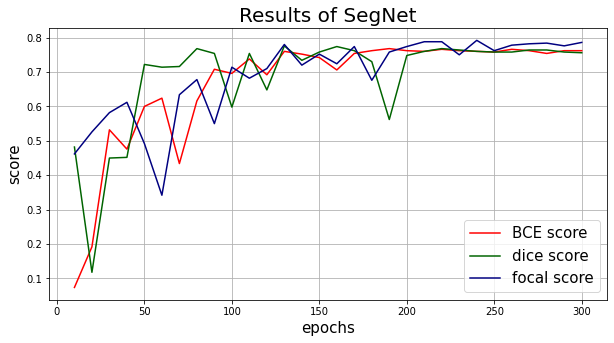

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(saving_epochs, model_BCE_score, label='BCE score', c='red')
plt.plot(saving_epochs, model_dice_score, label='dice score', c='darkgreen')
plt.plot(saving_epochs, model_focal_score, label='focal score', c='navy')
plt.title('Results of SegNet', fontsize=20)
plt.ylabel('score', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

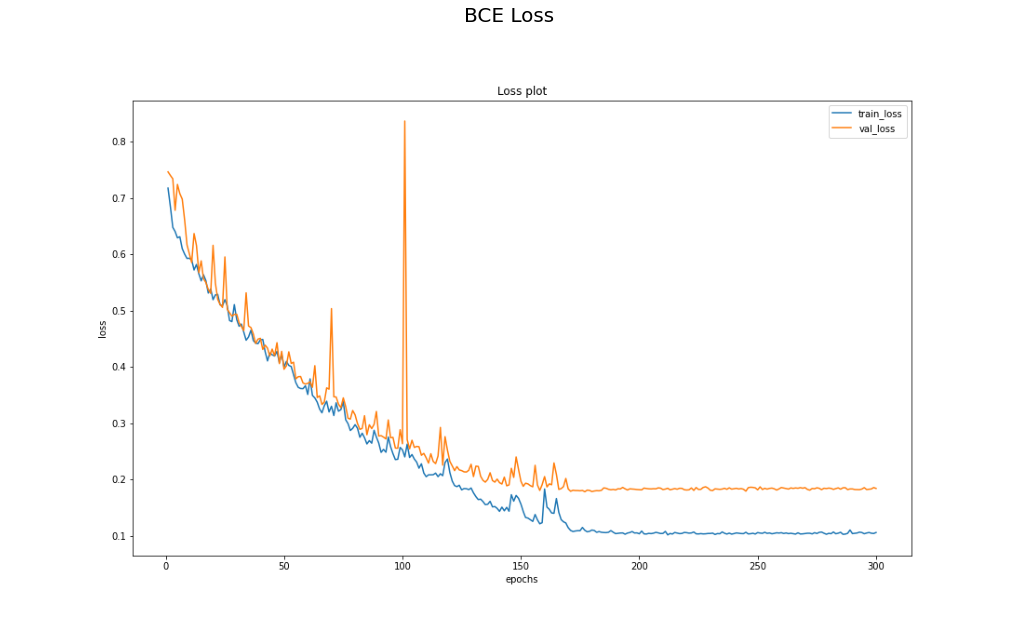

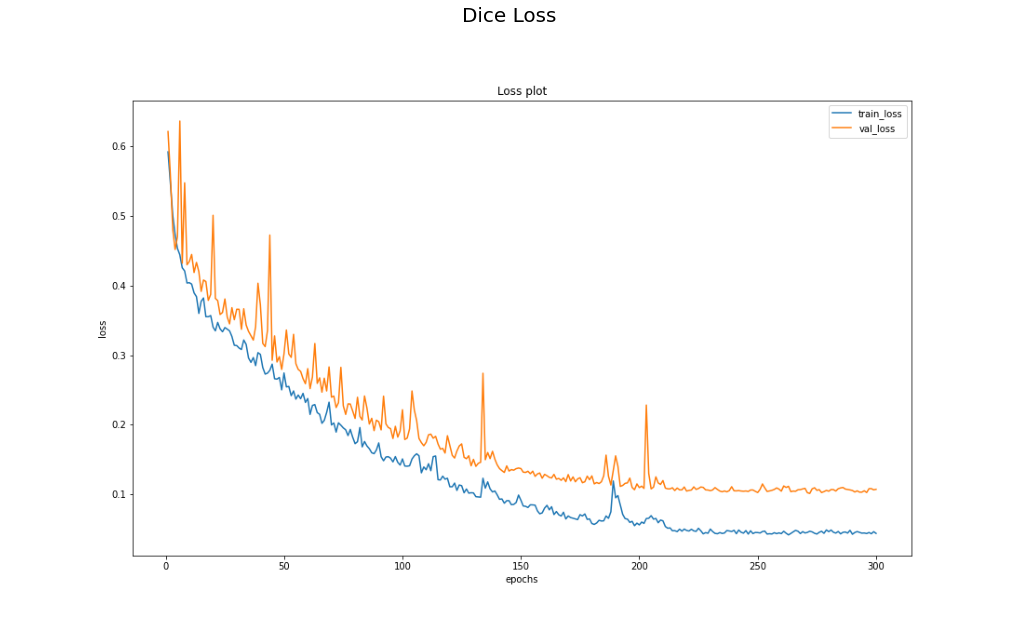

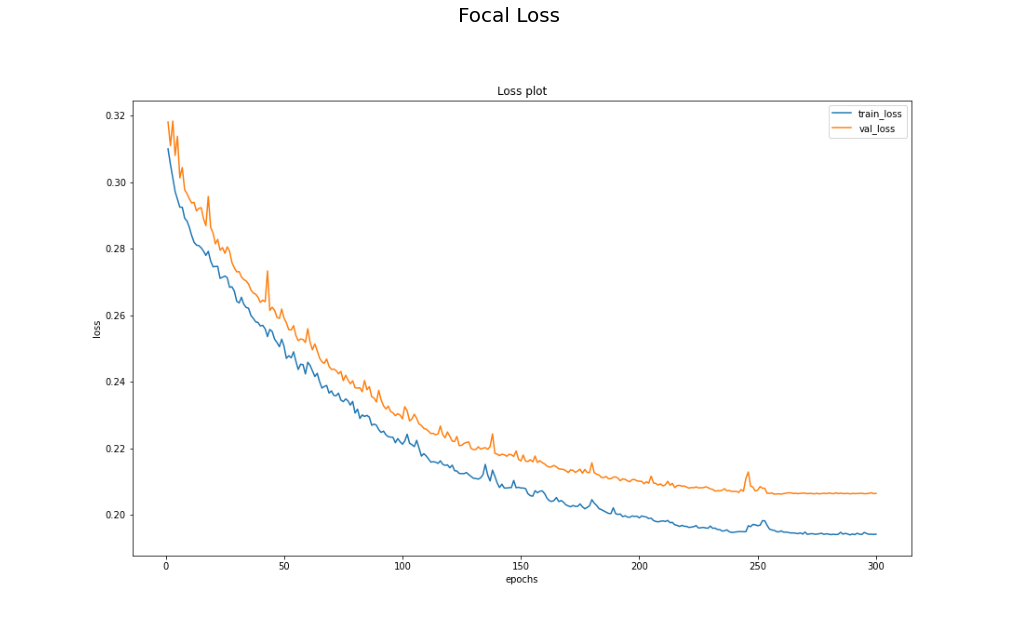

In [ ]:
names = ['BCE Loss', 'Dice Loss', 'Focal Loss']
for i in range(len(names)):
    img = mpimg.imread('loss plot of model {}.png'.format(i+1))
    fig, ax = plt.subplots(figsize=(18,18))
    plt.title(names[i], fontsize=20)
    fig.patch.set_visible(False)
    ax.axis('off')

    plt.imshow(img)
    plt.show()

-----------------------------------------------------------------------------------------
# U-Net

## U-Net (class) 

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padd = 1


        # 1
        self.enc_conv_1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_1_1 = nn.BatchNorm2d(num_features=64)
        self.enc_conv_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_1_2 = nn.BatchNorm2d(num_features=64)

        # 2
        self.enc_conv_2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_2_1 = nn.BatchNorm2d(num_features=128)
        self.enc_conv_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_2_2 = nn.BatchNorm2d(num_features=128)

        # 3
        self.enc_conv_3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_3_1 = nn.BatchNorm2d(num_features=256)
        self.enc_conv_3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_3_2 = nn.BatchNorm2d(num_features=256)
        self.enc_conv_3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_3_3 = nn.BatchNorm2d(num_features=256)
        
        # 4
        self.enc_conv_4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_4_1 = nn.BatchNorm2d(num_features=512)
        self.enc_conv_4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_4_2 = nn.BatchNorm2d(num_features=512)
        self.enc_conv_4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel, stride=1, padding=padd)
        self.bn_enc_4_3 = nn.BatchNorm2d(num_features=512)

        # bottleneck
        self.bottleneck_conv_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=kernel, stride=1, padding=1)
        self.bn_bottle_1 = nn.BatchNorm2d(num_features=1024)
        self.bottleneck_conv_2 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=kernel, stride=1, padding=1)
        self.bn_bottle_2 = nn.BatchNorm2d(num_features=512)

                                       # GO BACK!        

        # 4
        self.dec_conv_4_1 = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_4_1 = nn.BatchNorm2d(num_features=256)
        self.dec_conv_4_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_4_2 = nn.BatchNorm2d(num_features=256)
        self.dec_conv_4_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_4_3 = nn.BatchNorm2d(num_features=256)

        # 3
        self.dec_conv_3_1 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_3_1 = nn.BatchNorm2d(num_features=128)
        self.dec_conv_3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_3_2 = nn.BatchNorm2d(num_features=128)
        self.dec_conv_3_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_3_3 = nn.BatchNorm2d(num_features=128)

        # 2
        self.dec_conv_2_1 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_2_1 = nn.BatchNorm2d(num_features=64)
        self.dec_conv_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_2_2 = nn.BatchNorm2d(num_features=64)

        # 1
        self.dec_conv_1_1 = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=kernel, stride=1, padding=padd)
        self.bn_dec_1_1 = nn.BatchNorm2d(num_features=1)
        self.dec_conv_1_2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel, stride=1, padding=padd)


    def forward(self, x):

        # 1
        x = F.relu(self.bn_enc_1_1(self.enc_conv_1_1(x)), inplace=True)
        return_x1 = F.relu(self.bn_enc_1_2(self.enc_conv_1_2(x)), inplace=True)
        x, id1 = F.max_pool2d(return_x1, kernel_size=2, stride=2, return_indices=True)

        # 2
        x = F.relu(self.bn_enc_2_1(self.enc_conv_2_1(x)), inplace=True)
        return_x2 = F.relu(self.bn_enc_2_2(self.enc_conv_2_2(x)), inplace=True)
        x, id2 = F.max_pool2d(return_x2, kernel_size=2, stride=2, return_indices=True)

        # 3
        x = F.relu(self.bn_enc_3_1(self.enc_conv_3_1(x)), inplace=True)
        x = F.relu(self.bn_enc_3_2(self.enc_conv_3_2(x)), inplace=True)
        return_x3 = F.relu(self.bn_enc_3_3(self.enc_conv_3_3(x)), inplace=True)
        x, id3 = F.max_pool2d(return_x3, kernel_size=2, stride=2, return_indices=True)

        # 4
        x = F.relu(self.bn_enc_4_1(self.enc_conv_4_1(x)), inplace=True)
        x = F.relu(self.bn_enc_4_2(self.enc_conv_4_2(x)), inplace=True)
        return_x4 = F.relu(self.bn_enc_4_3(self.enc_conv_4_3(x)), inplace=True)
        x, id4 = F.max_pool2d(return_x4, kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        x = F.relu(self.bn_bottle_1(self.bottleneck_conv_1(x)), inplace=True)
        x = F.relu(self.bn_bottle_2(self.bottleneck_conv_2(x)), inplace=True)

                                       # GO BACK!
        # 4
        x = F.max_unpool2d(x, id4, kernel_size=2, stride=2)
        x = torch.cat([return_x4, x], 1)
        x = F.relu(self.bn_dec_4_1(self.dec_conv_4_1(x)), inplace=True)
        x = F.relu(self.bn_dec_4_2(self.dec_conv_4_2(x)), inplace=True)
        x = F.relu(self.bn_dec_4_3(self.dec_conv_4_3(x)), inplace=True)

        # 3 
        x = F.max_unpool2d(x, id3, kernel_size=2, stride=2)
        x = torch.cat([return_x3, x], 1)
        x = F.relu(self.bn_dec_3_1(self.dec_conv_3_1(x)), inplace=True)
        x = F.relu(self.bn_dec_3_2(self.dec_conv_3_2(x)), inplace=True)
        x = F.relu(self.bn_dec_3_3(self.dec_conv_3_3(x)), inplace=True)
        
        # 2
        x = F.max_unpool2d(x, id2, kernel_size=2, stride=2)
        x = torch.cat([return_x2, x], 1)
        x = F.relu(self.bn_dec_2_1(self.dec_conv_2_1(x)), inplace=True)
        x = F.relu(self.bn_dec_2_2(self.dec_conv_2_2(x)), inplace=True)
        
        # 1
        x = F.max_unpool2d(x, id1, kernel_size=2, stride=2)
        x = torch.cat([return_x1, x], 1)
        x = F.relu(self.bn_dec_1_1(self.dec_conv_1_1(x)), inplace=True)
        x = self.dec_conv_1_2(x)
        
        return x

## U-Net (BCE Loss)

In [ ]:
unet_model_bce = UNet().to(device)

optimizer = optim.Adam(unet_model_bce.parameters())
train(unet_model_bce, optimizer, bce_loss, MAX_EPOCHS, data_tr, data_val, my_epochs=saving_epochs, num=4)

In [ ]:
unet_BCE_score = []
for epoch in saving_epochs:
    unet_model_bce = torch.load('model {}.pth'.format(epoch))
    unet_BCE_score.append(score_model(unet_model_bce, iou_pytorch, data_val))

## U-Net (Dice Loss)

In [ ]:
unet_model_dice = UNet().to(device)

optimizer = optim.Adam(unet_model_dice.parameters())
train(unet_model_dice, optimizer, dice_loss, MAX_EPOCHS, data_tr, data_val, my_epochs=saving_epochs, num=5)

In [ ]:
unet_dice_score = []
for epoch in saving_epochs:
    unet_model_dice = torch.load('model {}.pth'.format(epoch))
    unet_dice_score.append(score_model(unet_model_dice, iou_pytorch, data_val))

## U-Net (Focal Loss)

In [ ]:
unet_model_focal = UNet().to(device)

optimizer = optim.Adam(unet_model_focal.parameters())
train(unet_model_focal, optimizer, focal_loss, MAX_EPOCHS, data_tr, data_val, my_epochs=saving_epochs, num=6)

In [ ]:
unet_focal_score = []
for epoch in saving_epochs:
    unet_model_focal = torch.load('model {}.pth'.format(epoch))
    unet_focal_score.append(score_model(unet_model_focal, iou_pytorch, data_val))

# U-Net (Summary)

In [ ]:
results2 = pd.DataFrame.from_dict(data={'BCE score': unet_BCE_score, 'dice score': unet_dice_score, 'focal score': unet_focal_score},\
                                 orient = 'index', columns = [str(x)+' epoch' for x in saving_epochs])
results2['best epoch'] = results2.idxmax(axis=1)
results2['best result'] = results2.iloc[:,:-1].max(axis=1)
results2

,10 epoch,20 epoch,30 epoch,40 epoch,50 epoch,60 epoch,70 epoch,80 epoch,90 epoch,100 epoch,110 epoch,120 epoch,130 epoch,140 epoch,150 epoch,160 epoch,170 epoch,180 epoch,190 epoch,200 epoch,210 epoch,220 epoch,230 epoch,240 epoch,250 epoch,260 epoch,270 epoch,280 epoch,290 epoch,300 epoch,best epoch,best result
BCE score,0.000,0.598,0.498,0.282,0.604,0.282,0.650,0.706,0.660,0.752,0.760,0.772,0.780,0.770,0.78,0.782,0.788,0.780,0.784,0.782,0.788,0.788,0.786,0.780,0.782,0.784,0.782,0.788,0.776,0.784,280 epoch,0.788
dice score,0.262,0.154,0.272,0.646,0.524,0.402,0.704,0.516,0.762,0.744,0.600,0.768,0.714,0.702,0.76,0.788,0.780,0.790,0.780,0.782,0.776,0.786,0.784,0.788,0.782,0.788,0.786,0.782,0.784,0.782,180 epoch,0.790
focal score,0.060,0.624,0.594,0.680,0.624,0.710,0.706,0.678,0.690,0.660,0.662,0.694,0.692,0.702,0.72,0.672,0.762,0.756,0.748,0.694,0.736,0.732,0.740,0.754,0.744,0.740,0.736,0.740,0.740,0.736,170 epoch,0.762


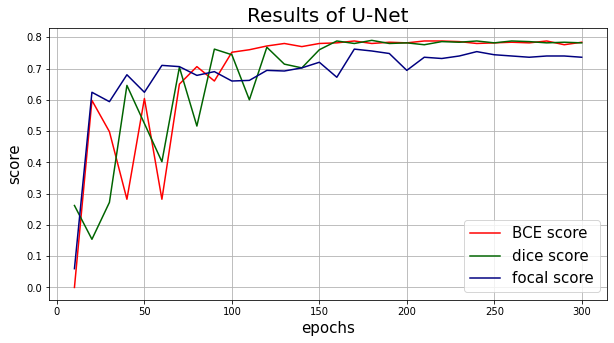

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(saving_epochs, unet_BCE_score, label='BCE score', c='red')
plt.plot(saving_epochs, unet_dice_score, label='dice score', c='darkgreen')
plt.plot(saving_epochs, unet_focal_score, label='focal score', c='navy')
plt.title('Results of U-Net', fontsize=20)
plt.ylabel('score', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(prop={'size': 15})
plt.grid()
plt.show()

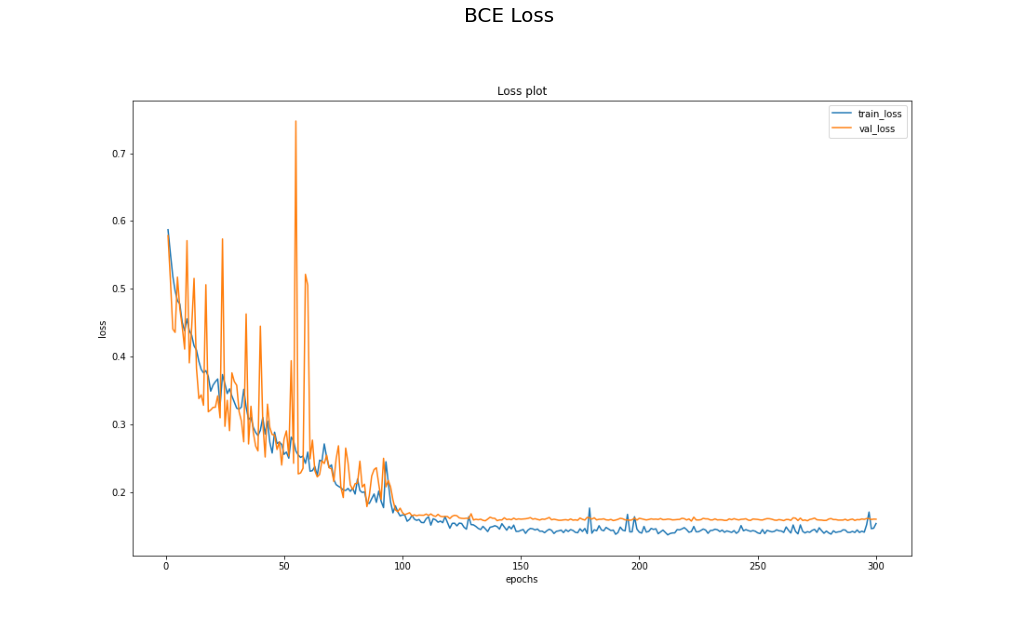

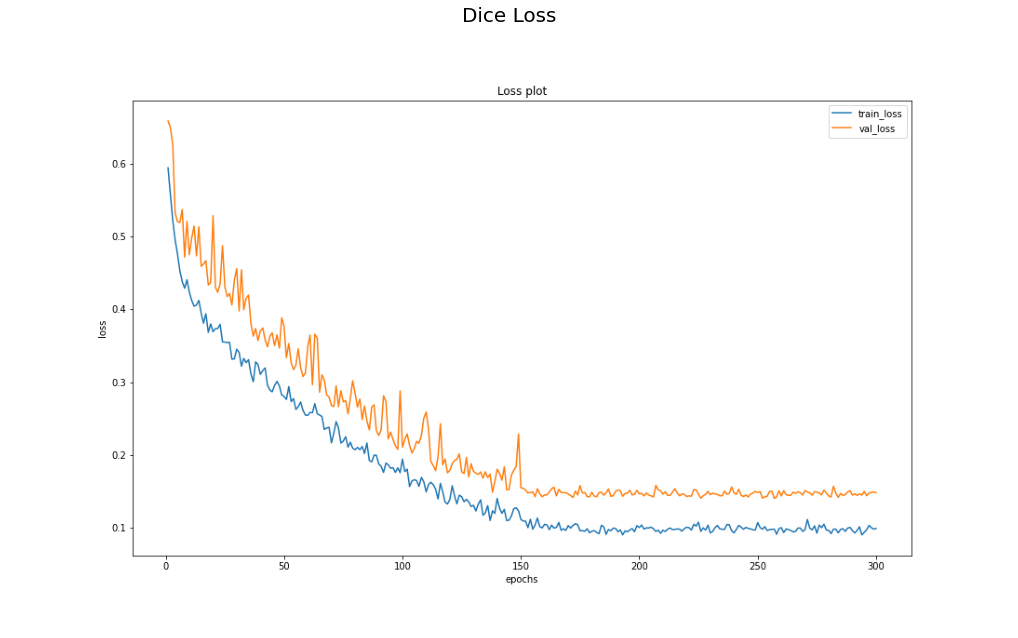

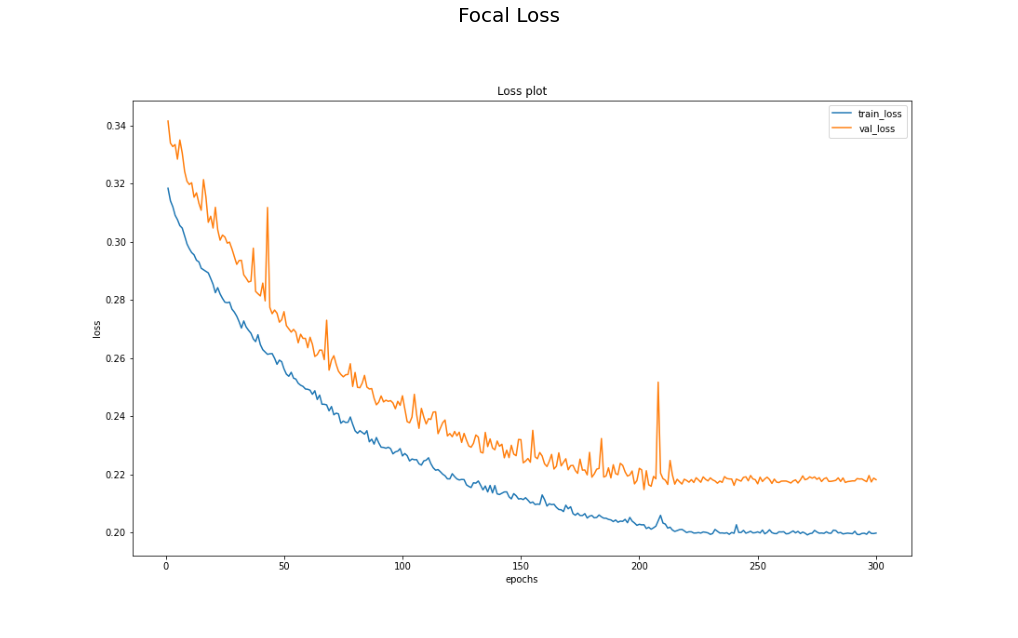

In [ ]:
names = ['BCE Loss', 'Dice Loss', 'Focal Loss']
for i in range(len(names)):
    img = mpimg.imread('loss plot of model {}.png'.format(i+4))
    fig, ax = plt.subplots(figsize=(18,18))
    plt.title(names[i], fontsize=20)
    fig.patch.set_visible(False)
    ax.axis('off')

    plt.imshow(img)
    plt.show()

-----------------------------------------------------------------------------------------
# **FINAL**

Построены архитектуры SegNet и U-Net с 3 функциями потерь: BCE, Dice, Focal.

Суммарно все 6 структур были обучены на 300 эпохах, модель на каждой 10 эпохе сохранялась для последующего подсчета метрики.

Результаты метрик, а также графики изменения лосса представлены в блоках SegNet (Summary) и U-Net (Summary).

Судя по полученным значениям, лучшая из полученных моделей - SegNet на Focal Loss, которая выдала результат метрики - **0.792 на 240 эпохе**.